
# Library of Congress Topic Analysis


## Attributions

This report contains information from [OhioLINK Circulation Data](https://www.oclc.org/research/areas/systemwide-library/ohiolink/circulation.html) which is made available by OCLC Online Computer Library Center, Inc. and OhioLINK under the [ODC Attribution License]( https://www.oclc.org/research/areas/systemwide-library/ohiolink/odcby.html).


## Imports

In [2]:
import pickle
import os
import random
import re
import nltk
import string
import LibraryTree as libtree
import copy

import spacy
import numpy as np
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel    
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize
from scipy.optimize import linear_sum_assignment

from collections import Counter
from csv import reader
from tabulate import tabulate
from matplotlib import pyplot as plt

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Bibliographic Data

Bibliograhic data is stored in .marc files that follow the MARC 21 standard for bibliographic data. MARC files are parsed to extract Library of Congress Call Numbers (LCCNs) for each item with a unique OCLC number. A unique OCLC number corresponds to a unique library resource (i.e. book, enyclopedia, article, etc.) 


### Loading Bibliographic Data

In [3]:
def load_data(file):
    with open (file, 'rb') as f:
        bibList = pickle.load(f)
        example = pickle.load(f)
    return bibList, example
bibList, example = load_data('ohioLCCData_withSummary.pkl')

### Example Bibliographic Data
(OCLC #, LCCN, Publication Date, Title, Summary)

In [4]:
print(bibList[0])

(1, ['PZ5'], '[1963]', 'The Rand McNally book of favorite pastimes /', ['Boys and girls in these four stories work hard to master ballet dancing, riding, baton twirling, and swimming.'])


## Library of Congress Structure 

Parse the libray of congress outline schedules to determine the basic structure of the library of congress classification (LCC) hieriarchy. Structure will be stored in a tree data structure. 

In [5]:
tree = libtree.LibraryTree()
tree.build_tree('lcco csv')
tree.build_hash()

### Example of LCC tree structure


In [6]:
print(tree.classes['A'])

0: A - General Works
	1: AC - Collections. Series. Collected works
		2: AC1-999 - Collections. Series. Collected works
			3: AC1-195 - Collections of monographs, essays, etc.
				4: AC1-8 - American and English
				4: AC9-195 - Other languages
			3: AC200 - Collections for Jewish readers
			3: AC801-895 - Inaugural and program dissertations
			3: AC901-995 - Pamphlet collections
			3: AC999 - Scrapbooks
	1: AE - Encyclopedias 
		2: AE1-(90) - Encyclopedias
			3: AE5-(90) - By language
	1: AG - Dictionaries and other general reference works
		2: AG2-600 - Dictionaries and other general reference works
	1: AI - Indexes
		2: AI1-21 - Indexes
	1: AM - Museums. Collectors and collecting
		2: AM1-(501) - Museums. Collectors and collecting
			3: AM10-100 - By country
			3: AM111-160 - Museology. Museum methods, technique, etc.
			3: AM200-(501) - Collectors and collecting
	1: AN - Newspapers
	1: AP - Periodicals
		2: AP1-(271) - Periodicals
			3: AP101-115 - Humorous periodicals
			3: AP200-2

## Parsing MARC Data

Parse the MARC records and place books into a library of congress tree strcuture 

In [7]:
'''
Extract marc data from items that have a LCC, title, 
and publication year
'''

# OCLC number, LCCN, year published, title
def extractLCCN(bibList):
    lccnDat = [list(item) for item in bibList if len(item[1]) != 0 
               and item[2] is not None and item[3] is not None]
    badChars = '*()+,[]/!-\\|'
    for item in lccnDat:
        for char in badChars:
            item[1][0] = item[1][0].replace(char, '').upper()
            item[3] = item[3].replace(char, '').lower()
        if type(item[2]) is list:
            item[2] = item[2][0] #no dates list of >1
    return lccnDat
lccnDat = extractLCCN(bibList)

In [8]:
'''
Find the index of the first digit in an LCCN
'''
def digitIdx(string):
    for idx, char in enumerate(string):
        if char.isdigit():
            return idx  
    return -1 

In [9]:
'''
Determine if a decimal provides additional information (a cutter)
or is a part of the LCCN
'''
def getDivision(subStr):
    dec_count = 0
    for idx, char in enumerate(subStr):
        if char == '.':
            dec_count += 1 
        if dec_count > 1: # second decimal is always a cutter
            return subStr[:idx]
        # decimal followed almost always a cutter (assume all are for simplicity)
        if not char.isdigit() and char != '.': 
            return subStr[:idx]
    return subStr

In [10]:
'''
Divide a LCCN into its components
'''
def getComponents(lcc):
    topClass = lcc[0]
    firstDigit = digitIdx(lcc)
    if firstDigit == -1:
        subClass = lcc[1:]
        division = None
    else:
        subClass = lcc[1:firstDigit]
        division = getDivision(lcc[firstDigit:])
        if division[-1] == '.':
            division = division[:-1]
        division = float(division)
    if subClass == '':
        subClass = None
    components = (topClass, subClass, division)
    return components

In [11]:
'''
Extract and regularize the format of MARC publication dates
'''
def formatDate(dateStr):
    xxxx  = r'\d\d\d\d'
    dateStr = dateStr.lower()
    if 'n.d.' in dateStr: #no date
        date = None 
    elif re.search(r'c\d\d\d\d|c \d\d\d\d', dateStr):
        # ASSUMPTION: use the earliest date
        date = min([int(d[1:]) for d in re.findall(r'c\d\d\d\d|c \d\d\d\d', dateStr)])
    elif re.search(r'c\.\d\d\d\d', dateStr):
        date = min([int(d[2:]) for d in re.findall(r'c\.\d\d\d\d', dateStr)])
    elif re.search(r'c\d\d\dl', dateStr):
        date = min([int(d[1:].replace('l', '1')) for d in re.findall(r'c\d\d\dl', dateStr)])
    elif re.search(r'\dc\d\d\d', dateStr):
        date = min([int(d.replace('c', '')) for d in re.findall(r'\dc\d\d\d', dateStr)])
    elif re.search(r'c9\d\d|c8\d\d', dateStr):
        date = min([int(d.replace('c', '1')) for d in re.findall(r'c9\d\d|c8\d\d', dateStr)])
    elif re.search(xxxx, dateStr) and 'c' not in dateStr and not re.search(r'^\d\d\d |^ \d\d\d |^\d\d\d\[', dateStr):
        date = min([int(d) for d in re.findall(xxxx, dateStr)])
    else:
        date = None
    return date

In [12]:
'''
Ensure a LCCN is valid
'''
def checkFormat(lccnDat, labels):
    count = 0
    validLCC = []
    digitIdxs = [-1, 1, 2, 3]
    for item in lccnDat:
        # for now just using first LCC for items w/multiple
        lcc = item[1][0]
        if len(lcc) > 2:
            firstDigit = digitIdx(lcc)
            # -1 in case where lcc is just something like AN
            if (lcc[0] in labels and firstDigit in [1, 2, 3]) or (len(lcc) <= 3 and firstDigit == -1):
                date = formatDate(item[2])
                if date is not None and date >= 1500 and date < 2022:
                    validLCC.append((item[0], getComponents(lcc), date, item[3], item[4]))
                    count += 1
    return validLCC, count

validLCC, count = checkFormat(lccnDat, tree.labels)

In [13]:
#sanity check - check lcc against lcc stored in classify (search by oclc num)
idx = random.randint(0, count-1)	
print(validLCC[idx])

(806880, ('Q', 'L', 676.0), 1942, 'birds across the sky ', [])


In [14]:
tree.count_items(validLCC)

## Analysis
### Basic Statistics

In [15]:
'''
Count the number of items that do not have a LCC
'''
def countMissing(bibList, empty, i):
    return len([item[0] for item in bibList if item[i] == empty])
                
missingLCCN = countMissing(bibList, [],  1)
missingDate = countMissing(bibList, None, 2)
missingTitle = countMissing(bibList, None, 3)

In [16]:
'''
Count the number of items with more than one LCC
'''
def countMultiple(bibList, i):
    return len([item[0] for item in bibList if len(item[i]) > 1])
multiLCCN = countMultiple(bibList, 1)

In [17]:
table = [["Library of\nCongress", len(lccnDat), count,  missingLCCN, 
          missingDate, missingTitle]]
print(tabulate(table, headers=["", "no. with\na LCCN", "no. with\nall data",
                               "no. without\na LCCN",
                               "no. without a\npublication date", 
                               "no. without\na title"]))

              no. with    no. with    no. without       no. without a    no. without
                a LCCN    all data         a LCCN    publication date        a title
----------  ----------  ----------  -------------  ------------------  -------------
Library of     5787518     5452201         982257               16051             21
Congress


### Date Analysis

In [18]:
# Seperate books by their century of publication
items_1900 = [item[1][0] for item in validLCC if item[2] >= 1900 and item[2] < 2000]
items_1500 = [item[1][0] for item in validLCC if item[2] < 1600]
items_1600 = [item[1][0] for item in validLCC if item[2] >= 1600 and item[2] < 1700]
items_1700 = [item[1][0] for item in validLCC if item[2] >= 1700 and item[2] < 1800]
items_1800 = [item[1][0] for item in validLCC if item[2] >= 1800 and item[2] < 1900]
items_2000 = [item[1][0] for item in validLCC if item[2] >= 2000]

In [19]:
dates = list(set([item[2] for item in validLCC]))
print(f'Earliest date: {min(dates)}\nLatest date: {max(dates)}\nDate span: {max(dates)-min(dates)} years')
print(f'Length of list of unique dates is {len(dates)}\n')

table = [["1500s", len(items_1500)], ["1600s", len(items_1600)],  ["1700s", len(items_1700)], 
          ["1800s", len(items_1800)], ["1900s", len(items_1900)], ['2000s', len(items_2000)]]
print(tabulate(table, headers=["Century", "Number\nof Books"]))

Earliest date: 1500
Latest date: 2010
Date span: 510 years
Length of list of unique dates is 511

Century        Number
             of Books
---------  ----------
1500s            4487
1600s           35716
1700s           36565
1800s          370776
1900s         4363511
2000s          641146


In [20]:
def get_percent(items, cat):
    return round(items.count(cat) / len(items), 3)*100

def get_count(items, cat):
    return items.count(cat)

In [21]:
table = [['1500s', get_count(items_1500, 'B'), get_count(items_1500, 'Q'), get_count(items_1500, 'T'), get_count(items_1500, 'H')], 
        ['1600s', get_count(items_1600, 'B'), get_count(items_1600, 'Q'), get_count(items_1600, 'T'), get_count(items_1600, 'H')], 
         ['1700s', get_count(items_1700, 'B'), get_count(items_1700, 'Q'), get_count(items_1700, 'T'), get_count(items_1700, 'H')], 
         ['1800s', get_count(items_1800, 'B'), get_count(items_1800, 'Q'), get_count(items_1800, 'T'), get_count(items_1800, 'H')], 
         ['1900s', get_count(items_1900, 'B'), get_count(items_1900, 'Q'), get_count(items_1900, 'T'), get_count(items_1900, 'H')], 
        ['2000s', get_count(items_2000, 'B'), get_count(items_2000, 'Q'), get_count(items_2000, 'T'), get_count(items_2000, 'H')]]
print(tabulate(table, headers=["Century", "No. Books in B\n(Phil. Psych.\nReligion)", "No. Books in\n Q (Science)", "No. Books in\nT (Technology)", "No. Book in\nH (Social\nSciences)"]))

Century      No. Books in B    No. Books in      No. Books in    No. Book in
              (Phil. Psych.     Q (Science)    T (Technology)      H (Social
                  Religion)                                        Sciences)
---------  ----------------  --------------  ----------------  -------------
1500s                  1427             523                21             86
1600s                 11313            1705               149            828
1700s                  5862            4283               196           1032
1800s                 53271           30528              5738          15206
1900s                402979          355104            272999         550697
2000s                 56368           60625             47664          94406


In [22]:
table = [['1500s', get_percent(items_1500, 'B'), get_percent(items_1500, 'Q'), get_percent(items_1500, 'T'), get_percent(items_1500, 'H')], 
        ['1600s', get_percent(items_1600, 'B'), get_percent(items_1600, 'Q'), get_percent(items_1600, 'T'), get_percent(items_1600, 'H')], 
         ['1700s', get_percent(items_1700, 'B'), get_percent(items_1700, 'Q'), get_percent(items_1700, 'T'), get_percent(items_1700, 'H')], 
         ['1800s', get_percent(items_1800, 'B'), get_percent(items_1800, 'Q'), get_percent(items_1800, 'T'), get_percent(items_1800, 'H')], 
         ['1900s', get_percent(items_1900, 'B'), get_percent(items_1900, 'Q'), get_percent(items_1900, 'T'), get_percent(items_1900, 'H')], 
        ['2000s', get_percent(items_2000, 'B'), get_percent(items_2000, 'Q'), get_percent(items_2000, 'T'), get_percent(items_2000, 'H')]]
print(tabulate(table, headers=["Century", "% Books in B\n(Phil. Psych.\nReligion)", "% Books in Q\n(Science)", "% Books in T\n(Technology)", "% Book in\nH (Social\nSciences)"]))

Century       % Books in B    % Books in Q    % Books in T    % Book in
             (Phil. Psych.       (Science)    (Technology)    H (Social
                 Religion)                                    Sciences)
---------  ---------------  --------------  --------------  -----------
1500s                 31.8            11.7             0.5          1.9
1600s                 31.7             4.8             0.4          2.3
1700s                 16              11.7             0.5          2.8
1800s                 14.4             8.2             1.5          4.1
1900s                  9.2             8.1             6.3         12.6
2000s                  8.8             9.5             7.4         14.7


### Analysis of books from the 20th century

In [23]:
'''
Store books based on their date of publication
'''
def build_time_dic(items, idx):
    time_dic = {}
    i = 0
    for item in items:
        if item[idx] in time_dic.keys():
            time_dic[item[idx]].append(item)
            i += 1
        # if a date has not been seen before
        elif item[idx] not in time_dic.keys():
            time_dic[item[idx]] = [item]
            i += 1
    return time_dic, i

In [24]:
'''
Create seperate LCC trees for each year
'''
def get_time_trees(time_dic):
    time_split_tree = {}
    for key, value in time_dic.items():
        time_tree = libtree.LibraryTree()
        time_tree.build_tree('lcco csv')
        time_tree.build_hash()
        time_tree.count_items(value)
        time_split_tree[key] = time_tree
    return time_split_tree

In [25]:
# Get all books published in the 19th century
after_1900 = [item for item in validLCC if item[2] >= 1900 and item[2] < 2000]
after_1900_dic, count = build_time_dic(after_1900, 2)
dates = list(after_1900_dic.keys())
dates.sort()
time_trees = get_time_trees(after_1900_dic)

#### Method 1: LCCs as Topics

In [26]:
'''
Helper function for getting the number of books published per year 
'''
def get_counts(node, node_dic, main_class, i):
    label = node.label
    if label == main_class and i == 1:
        label += '1'
    if label == main_class:
        i += 1
        
    if label in node_dic.keys():
        node_dic[label][1].append(node.num_items)
    else:
        node_dic[label] = (node.name, [node.num_items])

    for child in node.children:
        get_counts(child, node_dic, main_class, i) 

In [27]:
'''
Get data across time for class a node
'''
def get_data(main_class, time_trees, dates):
    node_dic = {}
    i = 0
    for date in dates:
        root = time_trees[date].classes[main_class]
        get_counts(root, node_dic, main_class, 0)
        i += 1
    return node_dic

In [28]:
Q_dat = get_data('Q', time_trees, dates)
B_dat = get_data('B', time_trees, dates)
T_dat = get_data('T', time_trees, dates)
H_dat = get_data('H', time_trees, dates)

In [29]:
def average(values):
    return sum(values) / len(values)

In [30]:
def topical_acceleration(v1, v2, span):
    return (v2 - v1)/span

In [31]:
def plot_across_time(values, dates):
    # Books published per year
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    for i in range(len(values)):
        ax.plot(dates, values[i][1], label=values[i][0])

    plt.legend(loc='upper left')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.title("Number of books published per year by topic")
    plt.xlabel('Year')
    plt.ylabel('Number of books')
    
    # culmulative number of books across time
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    for i in range(len(values)):
        culm_val = np.cumsum(values[i][1])
        ax.plot(dates, culm_val, label=values[i][0])
    plt.legend(loc='upper left')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.title("Culmulative number of books across time by topic")
    plt.xlabel('Year')
    plt.ylabel('Number of books')



In [32]:
def print_table(values, dates):
    table = [[val[0], average(val[1]), topical_acceleration(val[1][0], val[1][-1], dates[-1] - dates[0])] for val in values]
    print(tabulate(table, headers=["Topic", "Average\nrate of change", "Average\nAcceleration", ]))

Topic                                      Average         Average
                                    rate of change    Acceleration
--------------------------------  ----------------  --------------
Science                                    3548.67         83.2121
Social Sciences                            5503.42        128.909
Technology                                 2727.8          69.404
Philosophy. Psychology. Religion           4024.78         66.4141


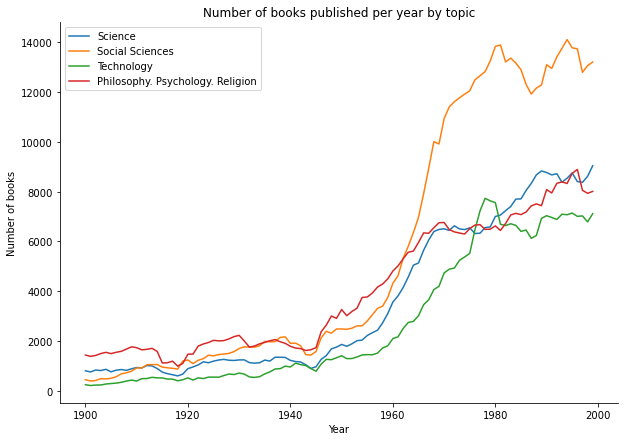

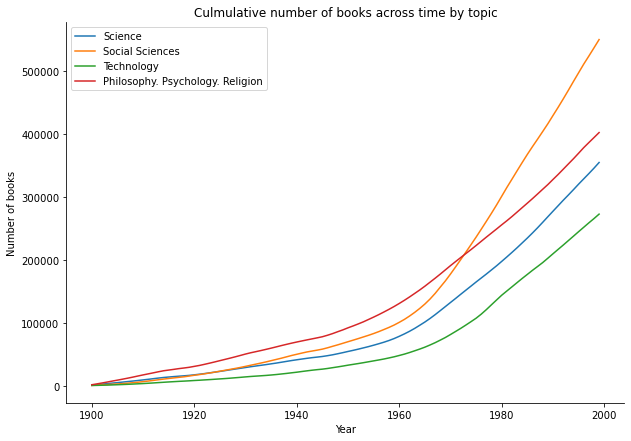

In [33]:
plot_across_time([Q_dat['Q'], H_dat['H'], T_dat['T'], B_dat['B']], dates)
print_table([Q_dat['Q'], H_dat['H'], T_dat['T'], B_dat['B']], dates)

In [34]:
'''
Read a file containing LCC subcategories 
'''
def get_topics(fp, data):
    topic_data = []
    with open(fp, 'r') as f:
        cats = f.read().replace(' ', '').split('\n')
    for cat in cats:
        topic_data.append(data[cat])
    return topic_data

In [35]:
'''
Get the n most and least changing topics in terms of average rate of change
'''
def get_n_changing(values, dates, n):
    change = [abs(average(val[1])) for val in values]
    most = np.argsort(change)[-n:]
    least = np.argsort(change)[:n]
    most_changing = [values[i] for i in most]
    least_changing = [values[i] for i in least]
    return most_changing, least_changing 

'''
Get the n most and least changing topics in terms of average acceleration
'''
def get_n_accelerating(values, dates, n):
    change = [abs(topical_acceleration(val[1][0], val[1][-1], dates[-1] - dates[0])) for val in values]
    most = np.argsort(change)[-n:]
    least = np.argsort(change)[:n]
    most_changing = [values[i] for i in most]
    least_changing = [values[i] for i in least]
    return most_changing, least_changing 


##### Initial analysis with science
This was done to test out the acceleration and rate of change metrics but was not a part of the final project

In [36]:
data_s = get_topics('science_topics.txt', Q_dat)

In [37]:
most_rate_s, least_rate_s = get_n_changing(data_s, dates, 8)
most_acc_s, least_acc_s = get_n_accelerating(data_s, dates, 8)

Topic                                                           Average         Average
                                                         rate of change    Acceleration
-----------------------------------------------------  ----------------  --------------
Meteorology. Climatology                                          68.55         1.66667
Atomic physics. Constitution and properties of matter             65.06         1.80808
Probabilities. Mathematical statistics                            60.64         2
Animal biochemistry                                               72.18         2.16162
Algebra                                                          101.08         2.30303
Analysis                                                         121.76         2.69697
Chordates. Vertebrates                                           147.86         4.50505
Electronic computers. Computer science                           263.59        20.1111


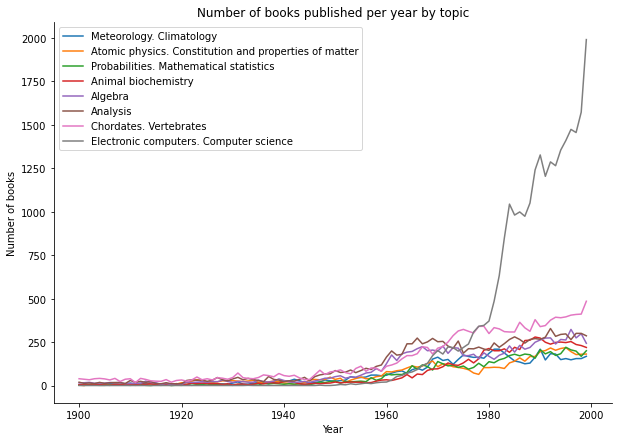

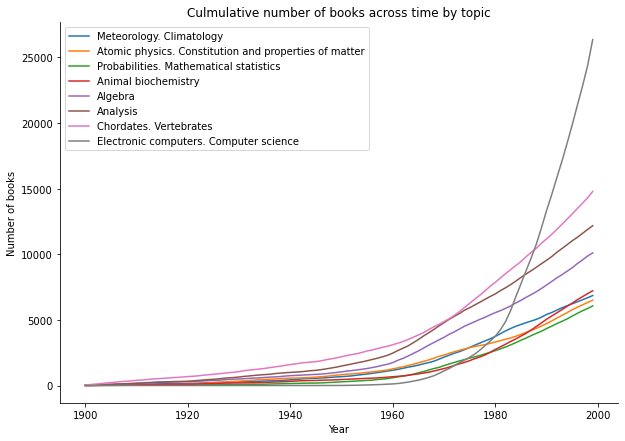

In [38]:
plot_across_time(most_acc_s, dates)
print_table(most_acc_s, dates)

In [39]:
print_table(most_rate_s, dates)

Topic                                            Average         Average
                                          rate of change    Acceleration
--------------------------------------  ----------------  --------------
Meteorology. Climatology                           68.55         1.66667
Physical and theoretical chemistry                 71.2          1.39394
Animal biochemistry                                72.18         2.16162
Invertebrates                                      83.97         1.30303
Algebra                                           101.08         2.30303
Analysis                                          121.76         2.69697
Chordates. Vertebrates                            147.86         4.50505
Electronic computers. Computer science            263.59        20.1111


In [40]:
print_table(least_acc_s, dates)

Topic                                     Average         Average
                                   rate of change    Acceleration
-------------------------------  ----------------  --------------
Geomagnetism                                 2.64        0
Economic biology                             0.13        0
Reproduction                                 1.05        0
Astrogeology                                 0.03        0
Geodesy                                      9.36        0.010101
Morphology                                   0.37        0.010101
Paleobotany                                  7.17        0.010101
Human and comparative histology              4.98        0.020202


In [41]:
print_table(least_rate_s, dates)

Topic                                                   Average         Average
                                                 rate of change    Acceleration
---------------------------------------------  ----------------  --------------
Astrogeology                                               0.03       0
Economic biology                                           0.13       0
Morphology                                                 0.37       0.010101
Reproduction                                               1.05       0
Geomagnetism                                               2.64       0
Regional anatomy                                           3.01       0.040404
Theoretical astronomy and celestial mechanics              3.04       0.0505051
Human embryology                                           3.05       0.020202


##### Analysis with Psychology

In [42]:
data_p = get_topics('psych_topics.txt', B_dat)

There are 38847 books classified in Psychology


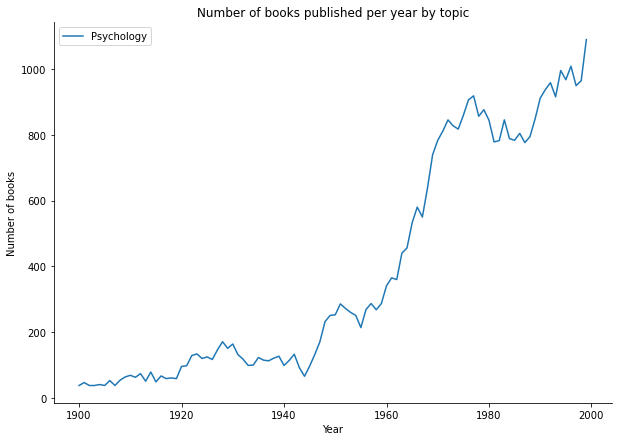

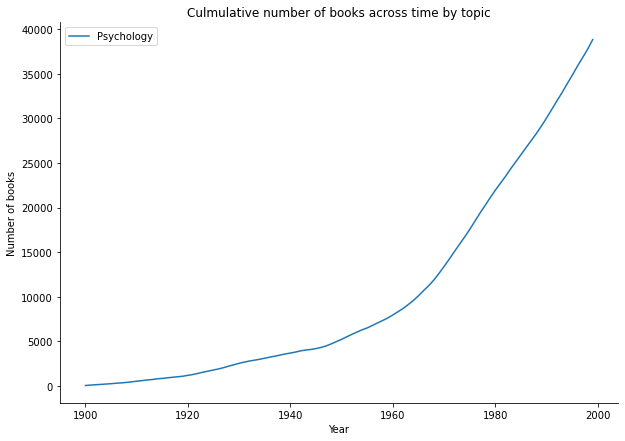

In [43]:
plot_across_time([data_p[0]], dates)
print(f"There are {sum(data_p[0][1])} books classified in Psychology")

In [74]:
most_rate, least_rate = get_n_changing(data_p[1:], dates, 8)
most_acc, least_acc = get_n_accelerating(data_p[1:], dates, 8)

##### Most Changing Psychology topics by acceleration

Topic                                                  Average         Average
                                                rate of change    Acceleration
--------------------------------------------  ----------------  --------------
Sensation. Aesthesiology                                 10.62        0.161616
Differential psychology. Individuality. Self              7.6         0.30303
Personality                                              20.33        0.383838
Psychoanalysis                                           29.72        0.818182
Affection. Feeling. Emotion                              32.22        1.09091
Applied psychology                                       44.36        1.72727
Developmental psychology                                 51.29        1.75758
Consciousness. Cognition                                 83.84        2.27273
Psychology                                              388.47       10.6162


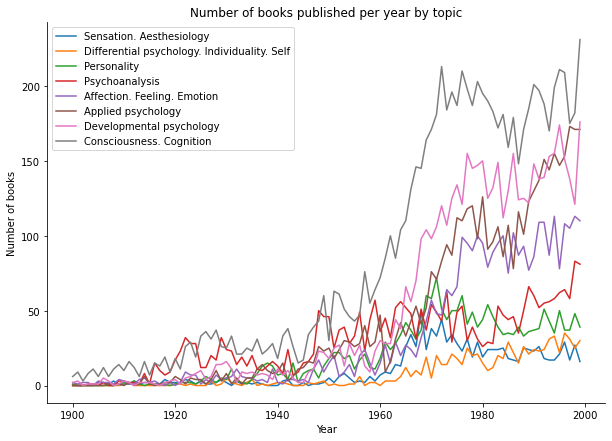

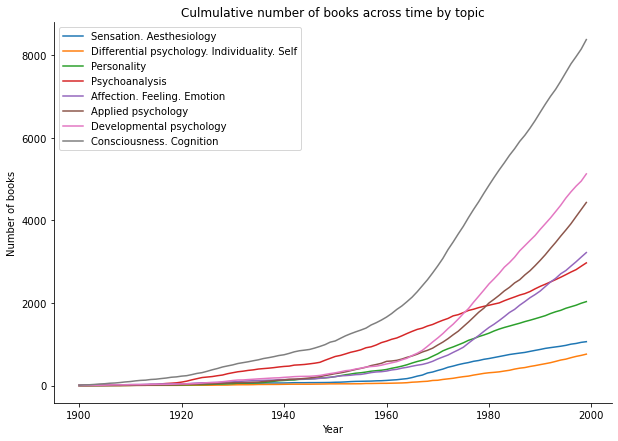

In [75]:
plot_across_time(most_acc, dates)
print_table(most_acc + [data_p[0]], dates)

##### Least changing Psychology subtopics by acceleration

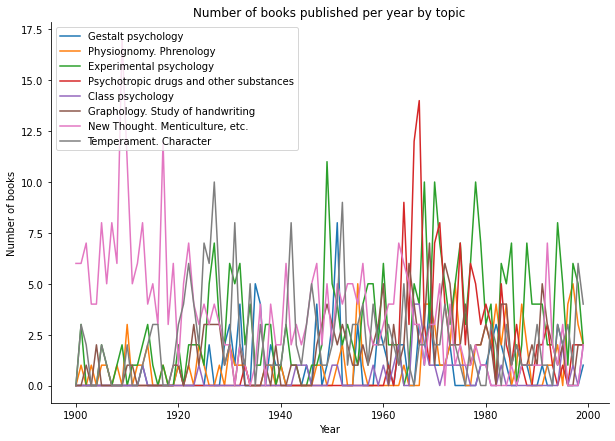

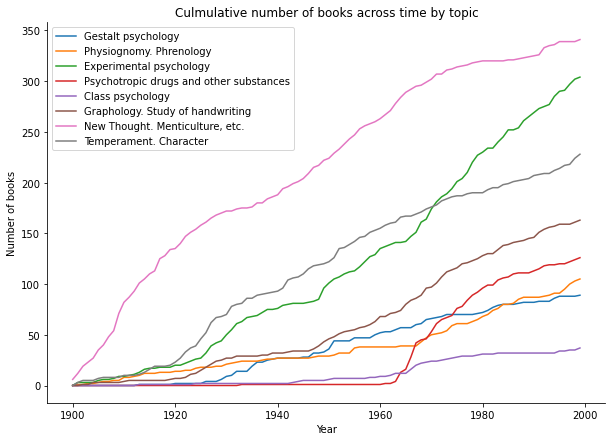

In [76]:
plot_across_time(least_acc, dates)

In [79]:
print_table(least_acc, dates)

Topic                                             Average         Average
                                           rate of change    Acceleration
---------------------------------------  ----------------  --------------
Gestalt psychology                                   0.89        0.010101
Physiognomy. Phrenology                              1.05        0.020202
Experimental psychology                              3.04        0.020202
Psychotropic drugs and other substances              1.26        0.020202
Class psychology                                     0.37        0.020202
Graphology. Study of handwriting                     1.63        0.020202
New Thought. Menticulture, etc.                      3.41       -0.040404
Temperament. Character                               2.28        0.040404


##### Most and least changing psychology subtopics by rate of change

In [78]:
print_table(most_rate, dates)

Topic                                                  Average         Average
                                                rate of change    Acceleration
--------------------------------------------  ----------------  --------------
Differential psychology. Individuality. Self              7.6         0.30303
Sensation. Aesthesiology                                 10.62        0.161616
Personality                                              20.33        0.383838
Psychoanalysis                                           29.72        0.818182
Affection. Feeling. Emotion                              32.22        1.09091
Applied psychology                                       44.36        1.72727
Developmental psychology                                 51.29        1.75758
Consciousness. Cognition                                 83.84        2.27273


In [80]:
print_table(least_rate, dates)

Topic                                             Average         Average
                                           rate of change    Acceleration
---------------------------------------  ----------------  --------------
Class psychology                                     0.37       0.020202
Gestalt psychology                                   0.89       0.010101
Physiognomy. Phrenology                              1.05       0.020202
The hand. Palmistry                                  1.14      -0.040404
Psychotropic drugs and other substances              1.26       0.020202
Graphology. Study of handwriting                     1.63       0.020202
Psychological tests and testing                      1.66       0.0505051
Motivation                                           2.04       0.0909091


#### Method 2: Topic Modeling

agreement algorithm: http://derekgreene.com/papers/greene14topics.pdf
nmf: https://researchrepository.ucd.ie/bitstream/10197/6482/1/insight_publication.pdf

In [51]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  
nlp.add_pipe('sentencizer')  

tree_1900s = libtree.LibraryTree()
tree_1900s.build_tree('lcco csv')
tree_1900s.build_hash()
tree_1900s.count_items(after_1900)

In [52]:
vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 1), preprocessor=' '.join, norm='l1')

In [53]:
'''
Get all titles from a node in the LCC tree
'''
def get_titles(node):
    all_titles = node.items
    random.shuffle(all_titles)
    test_titles = all_titles[:20]
    train_titles = all_titles[10:]
    return train_titles, test_titles

In [54]:
'''
Supplement a title with a summary
'''
def add_summary(title, summary):
    combined_text = title + " " + " ".join(summary)
    return combined_text

In [55]:
'''
Preprocess titles. Remove punctuation and stopwords. Lowercase and lemmatize the words 
then seperate into tokens. 
'''
def process_titles(title_dat, summary):
    stop_words = stopwords.words('english')
    processed_titles = []
    i = 0
    # pattern for removing stop words
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
    for title, date, summary in title_dat:
        if summary:
            title = add_summary(title, summary)
        title = pattern.sub('', title)
        title = " ".join([token.lemma_ for token in nlp(title)])
        # remove numbers
        title = re.sub(r'\d+', '', title)
        # remove punctuation
        title = re.sub(r'[^\w\s]',' ', title)
        # get rid of large spaces
        title = title = re.sub(r" +", " ", title)
        title_words = title.split()
        # tokenize
        title_words = [word for word in title_words if len(word)>1]
        processed_titles.append((title_words, date))
        i += 1
        if i%5000 == 0:
            print(f'{i} titles processed')
    print(f'Finished processing {len(processed_titles)} titles in {node.name}.')
    return processed_titles

In [56]:
'''
Jaccars similarity
'''
def jaccard_sim(l1, l2):
    s1 = set(l1)
    s2 = set(l2)
    sim = len(s1.intersection(s2)) / len(s1.union(s2)) 
    return sim

In [57]:
'''
Average jaccard similarity as defined by Greene et al. 
'''
def avg_jaccard(l1, l2, t=None):
    if t is None:
        t = len(l1)
    jaccard_sum = 0
    for d in range(1, t+1):
        l1_d = l1[:d]
        l2_d = l2[:d]
        sim = jaccard_sim(l1_d, l2_d)
        jaccard_sum += sim
    return jaccard_sum / t

In [58]:
'''
Agreement as defined by Greene et al. 
'''
def agreement(m1, m2):
    k = len(m1)
    sim_mat = np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            average = avg_jaccard(m1[i], m2[j])
            sim_mat[i, j] = average
    row_idx, col_idx = linear_sum_assignment(sim_mat, maximize=True)
    return sim_mat[row_idx, col_idx].sum() / k

In [59]:
'''
Get top terms associated with a topic
'''
def get_top_n_words(model, feats, n):
    topics = []
    for topic in model.components_:
        topics.append([feats[i] for i in topic.argsort()[:-n - 1:-1]])
    return topics

In [60]:
'''
Print n-most associated terms with a topic
'''
def print_topics(model, n, feats):
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feats[i] for i in topic.argsort()[:-n - 1:-1]]))

In [61]:
'''
Compute stability and coherence for different values of k 
'''
def test_k(t_mat, k_vals, beta, tao, max_iter, num_terms, feats, titles_no_date):
    stability_scores = []
    models = []
    coherences = []
    dic = Dictionary(titles_no_date)
    corpus = [dic.doc2bow(title) for title in titles_no_date]
    # for each k
    for k in k_vals:
        print(f'Performing NMF with {k} topics')
        rows = t_mat.shape[0]
        
        # initialize the model
        nmf = NMF(n_components=k, init='nndsvd', max_iter=max_iter)
        W = nmf.fit_transform(t_mat)
        s0 = get_top_n_words(nmf, feats, num_terms)
        nmf_i = NMF(n_components=k, init='nndsvd', max_iter=max_iter)

        num_samples = round(beta * rows)
        stability = 0
        for i in range(tao):
            # sample from data and generate a model 
            idx = np.random.choice(rows, size=num_samples, replace=False)
            t_mat_i = t_mat[idx]
            W_i = nmf_i.fit_transform(t_mat_i)
            # compute agreement between top n words
            si = get_top_n_words(nmf_i, feats, num_terms)      
            stability += agreement(s0, si)
        # compute overall stability of k-topic model
        stability = stability/tao
        stability_scores.append(stability)
        # compute coherence of k-topic model
        cm = CoherenceModel(topics=s0, texts=titles_no_date, dictionary=dic, coherence='c_v')
        coherence = cm.get_coherence()
        coherences.append(coherence)
        models.append(nmf)
        print(f'Agreement score: {round(stability, 4)}\nCoherence: {round(coherence, 4)}')
    return models, stability_scores, coherences

In [62]:
'''
Format data for plotting
'''
def format_data(W, text_data):
    predicted_topics = [np.argsort(title)[::-1][0] for title in W]   
    num_topics = W.shape[1]
    pub_dates = [date for _, date in text_data]
    date_set = list(set(pub_dates))
    date_set.sort()
    topic_dic = {i: {d: 0 for d in dates} for i in range(num_topics)}
    tm_across_time = []

    for i in range(len(predicted_topics)):
        date = pub_dates[i]
        topic = predicted_topics[i]
        topic_dic[topic][date] += 1
        
    for i in range(num_topics):
        topic_dat = []
        for d in date_set:
            topic_dat.append(topic_dic[i][d])
        tm_across_time.append((i, topic_dat))
    
    return tm_across_time

In [63]:
'''
Assign held out books topics 
'''
def check_topics(model, test_titles):
    processed_titles = process_titles(test_titles, False)
    titles_no_date = [title for title, _ in processed_titles]
    tfidf = vectorizer.transform(titles_no_date)
    W = model.transform(tfidf)
    predicted_topics = [np.argsort(title)[::-1][0] for title in W]  
    print('Title\t\tTopic')
    for i in range(len(test_titles)):
        print(f'{predicted_topics[i]}\t\t{test_titles[i][0]}')

In [64]:
'''
Plot coherence and stability
'''
def plot_metrics(k_vals, stability, coherence):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    ax.plot(k_vals, stability, marker='o')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('K')
    plt.xticks(k_vals) 
    plt.ylabel('Stability Score')
    plt.ylim(0, 1.0)
    
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    ax.plot(k_vals, coherence, marker='o')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('K')
    plt.xticks(k_vals) 
    plt.ylabel('Coherence')
    plt.ylim(0, 0.8)


To speed up the notebook just run the model with k_vals = [24]

In [65]:
# Run method 2 on the data
node = tree_1900s.hash_table['B']['BF'][(1.0, 990.0)]
train_titles, test_titles = get_titles(node)
processed_titles = process_titles(train_titles, False) # summary is False because there were not enough summaries 
titles_no_date = [title for title, _ in processed_titles]
tfidf = vectorizer.fit_transform(titles_no_date)
print(f"There are {node.num_items} texts in Psychology")
k_vals = [6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
# k_vals = [10]
feats = vectorizer.get_feature_names()
print(f'There are {tfidf.shape[1]} tokens')

5000 titles processed
10000 titles processed
15000 titles processed
20000 titles processed
25000 titles processed
30000 titles processed
35000 titles processed
Finished processing 38837 titles in Psychology.
There are 38847 texts in Psychology
There are 4041 tokens


In [66]:
models, score, coherences = test_k(tfidf, k_vals, 0.8, 100, 500, 10, feats, titles_no_date)

Performing NMF with 6 topics
Agreement score: 0.8605
Coherence: 0.2524
Performing NMF with 8 topics
Agreement score: 0.7203
Coherence: 0.2764
Performing NMF with 10 topics
Agreement score: 0.6597
Coherence: 0.291
Performing NMF with 12 topics
Agreement score: 0.7448
Coherence: 0.3357
Performing NMF with 14 topics
Agreement score: 0.7754
Coherence: 0.3309
Performing NMF with 16 topics
Agreement score: 0.7148
Coherence: 0.339
Performing NMF with 18 topics
Agreement score: 0.7494
Coherence: 0.351
Performing NMF with 20 topics
Agreement score: 0.8171
Coherence: 0.3525
Performing NMF with 22 topics
Agreement score: 0.7931
Coherence: 0.3487
Performing NMF with 24 topics
Agreement score: 0.7857
Coherence: 0.3734
Performing NMF with 26 topics
Agreement score: 0.782
Coherence: 0.3795


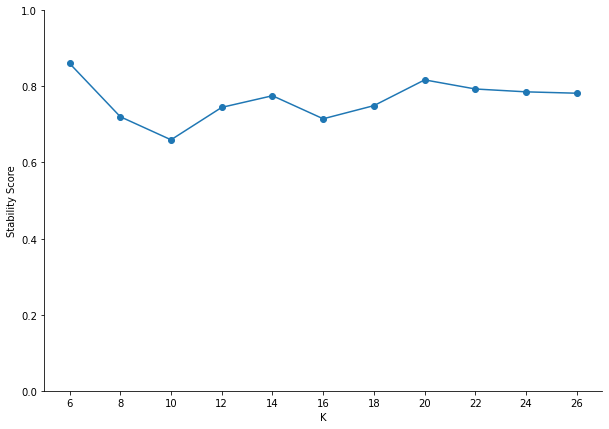

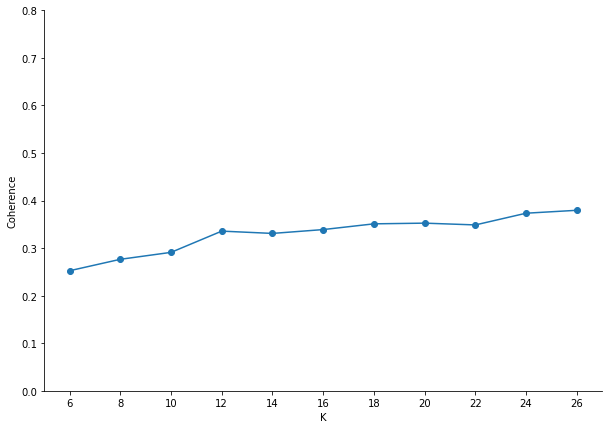

In [67]:
plot_metrics(k_vals, score, coherences)

In [68]:
nmf = models[-2]
W = nmf.transform(tfidf)

##### Discovered topics

In [69]:
print_topics(nmf, 6, feats)


Topic  0
psychology, history, experimental, general, apply, principle

Topic  1
personality, assessment, culture, adjustment, social, power

Topic  2
child, young, conception, world, death, stress

Topic  3
human, nature, motivation, understand, aggression, communication

Topic  4
introduction, counseling, general, jung, modern, communication

Topic  5
mind, philosophy, body, power, evolution, concept

Topic  6
behavior, modification, principle, learn, analysis, understand

Topic  7
development, lifespan, adolescent, adult, moral, social

Topic  8
memory, learn, cognition, book, improve, work

Topic  9
psychoanalysis, general, paper, history, outline, religion

Topic  10
theory, practice, counseling, research, application, motivation

Topic  11
perception, visual, sensation, communication, cognition, approach

Topic  12
man, search, woman, symbol, world, genius

Topic  13
life, everyday, work, stress, mean, live

Topic  14
freud, sigmund, jung, unconscious, postfreudian, woman

Topic 

In [70]:
check_topics(nmf, test_titles)

Finished processing 20 titles in Psychology.
Title		Topic
4		body of knowledge an introduction to bodymind psychology 
3		dna and destiny : nature and nurture in human behavior 
20		negotiating in adult learning 
0		the psychology of symbolic activity
4		an introduction to psychology
21		understanding representation in the cognitive sciences does representation need reality? 
17		el hombre mediocre; ensayo moral sobre la mediocridad humana como causa de rutina hipocresia y domesticidad en las sociedades contemporaneas con utiles reflexiones de idealismo experimental para que los jovenes procuren evitarla educando libremente su ingenio su virtud y su dignidad.
17		hagenim shel hanatsim 
0		psychbooks 1990 : books & chapters in psychology
19		the relationship between the level of aspiration and performance in selected motor tasks
19		a conceptual model of incentive values for explaining and predicting preference for selected physical activities
4		the psychology of c.g. jung : an introdu

##### Most changing topics by acceleration

  Topic           Average         Average
           rate of change    Acceleration
-------  ----------------  --------------
      8             12.22        0.454545
     20             13.54        0.484848
     10             19.08        0.585859
     21             18.27        0.656566
     19             41.58        0.838384
      0             36.29        0.949495
     22             35.07        0.959596
     13             42.96        1.72727


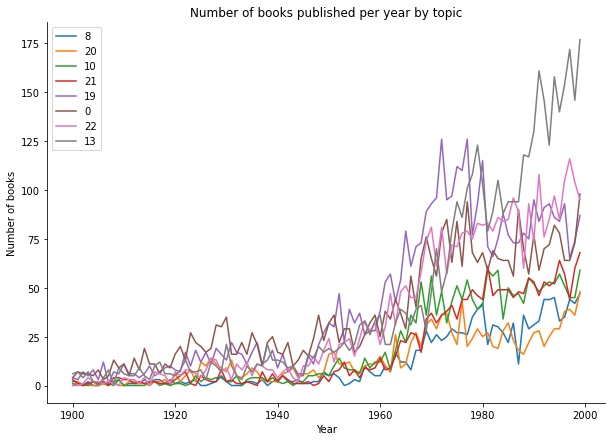

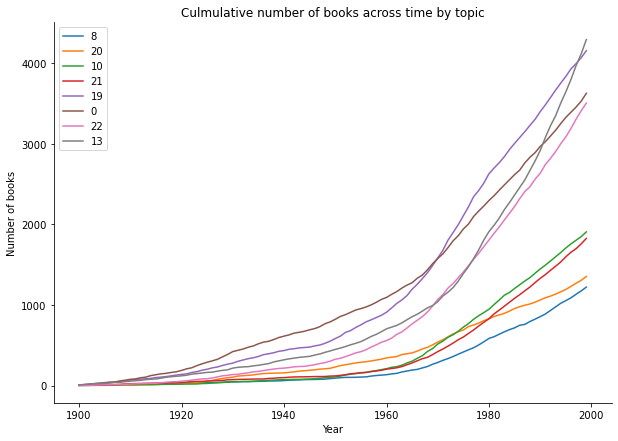

In [71]:
tm_across_time = format_data(W, processed_titles)
most_acc_t, least_acc_t = get_n_accelerating(tm_across_time, dates, 8)
plot_across_time(most_acc_t, dates)
print_table(most_acc_t, dates)

##### Least changing topics by acceleration

In [72]:
print_table(least_acc_t, dates)

  Topic           Average         Average
           rate of change    Acceleration
-------  ----------------  --------------
      1              9.64       0.0909091
     23             19.61       0.10101
     17             12.42       0.111111
      4              7.48       0.131313
      6              8.3        0.151515
      9              8.24       0.222222
     12              9.82       0.232323
     11              8.34       0.232323


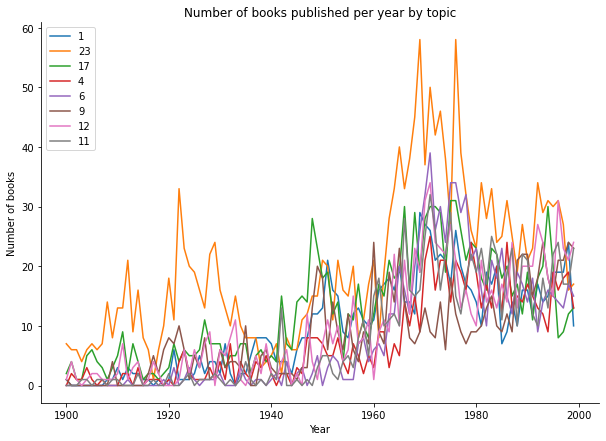

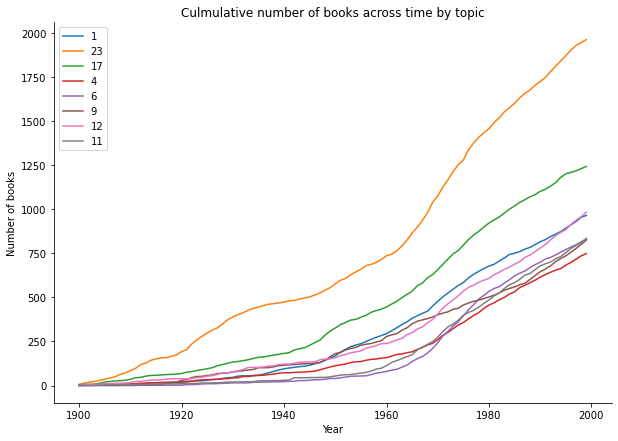

In [73]:
plot_across_time(least_acc_t, dates)